-----
## Import Libraries
-----

In [1]:
import openai
from openai import OpenAI
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import time
import re
import os
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

----
## Set OpenAI key as Environment and create OpenAI client
----

In [ ]:
# set the OPENAI API key as environment
os.environ['OPENAI_API_KEY'] = "Enter your key here"

# create an OPEMAI client instance for API calls
client = OpenAI()

----
## Load and Preprocess Data
----

In [3]:
def load_data(file_name, limit=100):
    """
    Load and prepare the dataset, limited to specified number of rows
    
    Args:
        file_path: Path to CSV file
        limit: Maximum number of rows to use (equally divided between classes)
        
    Returns:
        DataFrame with balanced samples
    """
    # Read the csv file into a dataframe
    df = pd.read_csv(file_name)
    
    # Check and standardize column names
    df['label'] = df['generated'].map({0: 'Human', 1: 'AI'})
  
    # Limit to balanced sample of 100 rows
    samples_per_class = limit // 2
    
    # Create separate dataframes based on the label
    human_df = df[df['label'] == 'Human']
    ai_df = df[df['label'] == 'AI']
    
    # Sample equally from each class
    human_sample = human_df.sample(samples_per_class, random_state=42)
    ai_sample = ai_df.sample(samples_per_class, random_state=42)
    
    # Combine and shuffle
    balanced_df = pd.concat([human_sample, ai_sample]).sample(frac=1, random_state=42)
    
    print(f"Loaded {len(balanced_df)} rows ({samples_per_class} from each class)")
    
    return balanced_df


In [ ]:
# Create a dataframe using load_data function
df = load_data('AI_Human.csv')

Loaded 100 rows (50 from each class)


----
## Create a function to give prompt and call the API
----

In [ ]:
def call_api(text, client, model="gpt-4o"):
    """
    Classify text as Human or AI written with confidence score
    
    Args:
        text: The text to classify
        client: OpenAI client instance
        model: Which OpenAI model to use
        
    Returns:
        tuple: (verdict, confidence_score, response_content)
    """
    # Provide instructions to the model to provide evidence for both Human and AI authorship, a confidence score and final verdict in the prompt
    prompt = f"""Analyze whether this text was written by a human or AI. 
    
    Text: {text}
    
    First, list specific evidence that suggests human authorship.
    Second, list specific evidence that suggests AI authorship.
    Third, provide a confidence score from 0-100 (where 0 is definitely human, 100 is definitely AI).
    Finally, provide your verdict: 'Human' or 'AI'.
    
    Format your answer exactly like this:
    Evidence for human:
    - point 1
    - point 2
    
    Evidence for AI:
    - point 1
    - point 2
    
    Confidence: [0-100]
    
    Verdict: Human/AI"""
    
    messages = [
        {"role": "system", "content": "You are an expert at detecting AI-generated text."},
        {"role": "user", "content": prompt}
    ]
    
    try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0
        )
        
        result = response.choices[0].message.content
        
        # Extract confidence using regex
        confidence_match = re.search(r'Confidence:\s*(\d+)', result)
        if confidence_match:
            confidence = int(confidence_match.group(1))
        else:
            # If extraction fails, default to a confidence score of 0
            confidence = 50  # Default to uncertain
        
        # Extract verdict using regex
        verdict_match = re.search(r'Verdict:\s*(Human|AI)', result)
        if verdict_match:
            verdict = verdict_match.group(1)
        else:
            # Fallback parsing
            verdict = "AI" if "AI" in result.split("\n")[-1] else "Human"
        
        return verdict, confidence, result
        
    except Exception as e:
        print(f"Error in API call: {e}")
        return "Error", 0, str(e)


----
## Create a function to classify the dataset and store final results in a results datarame and output of the model in a cache file
----

In [15]:
def classify_dataset(df, client, model="gpt-4o", cache_file = None):
    """
    Classify texts in a dataframe
    
    Args:
        df: DataFrame with 'text' column
        client: OpenAI client
        model: Which model to use
        cache_file: File to cache results to avoid redundant API calls
        
    Returns:
        DataFrame with classification results
    """
    # Create a copy of the input dataframe to add classification results
    cache = {}
    results_df = df.copy()

    # Load cache if it exists
    cache = {}
    if cache_file and os.path.exists(cache_file):
        try:
            with open(cache_file, 'r') as f:
                cache = json.load(f)
            print(f"Loaded {len(cache)} cached results")
        except:
            print("Error loading cache, starting fresh")
            cache = {}
    
    # Initialize columns for storing the results
    results_df['predicted'] = None
    results_df['confidence'] = None
    results_df['api_response'] = None
    
    # Iterate over each row of the dataframe with a progress bar showed using tqdm to process each text
    for idx, row in tqdm(results_df.iterrows(), total=len(results_df), desc="Classifying texts"):
        unique_id = str(hash(row['text']))  # Create a unique ID for each text
        if unique_id in cache:
        # Retrieve the previously stored result if available
            verdict, confidence, response = cache[unique_id]
        else:
            # Otherwise, call the API to classify the text and save the result
            verdict, confidence, response = call_api(row['text'], client, model=model)
            cache[unique_id] = (verdict, confidence, response)
            # Optionally, update the cache file every 5 new results (to save progress)
            if cache_file and (len(cache) % 5 == 0):
                with open(cache_file, 'w') as f:
                    json.dump(cache, f)
            time.sleep(3)  # Pause to respect API rate limits
        # Save the classification results (verdict and confidence) in our results table
        results_df.at[idx, 'predicted'] = verdict
        results_df.at[idx, 'confidence'] = confidence
        results_df.at[idx, 'api_response'] = response

    # After processing all texts, save the cache to a file (if used)
    if cache_file:
        with open(cache_file, 'w') as f:
            json.dump(cache, f)
    
    return results_df

In [ ]:
results_df = classify_dataset(df, client) # run the classify_dataset function and generate the results dataframe

Classifying texts: 100%|██████████| 100/100 [11:17<00:00,  6.78s/it]


----
## Create a function to evaluate results of the model
----

In [17]:
def evaluate_results(results_df):
    """Evaluate the classification results"""
    # Filter out rows where predictions resulted in an error
    valid_results = results_df[results_df['predicted'] != 'Error'].copy()
    
    # Calculate metrics
    accuracy = accuracy_score(valid_results['label'], valid_results['predicted'])
    
    # For ROC AUC, convert confidence to a score where higher means more likely AI
    # 0 confidence = definitely human, 100 confidence = definitely AI
    valid_results['ai_score'] = valid_results['confidence'] / 100.0
    
    # Convert true labels to binary for ROC calculation
    valid_results['true_binary'] = (valid_results['label'] == 'AI').astype(int)
    
    # Calculate ROC AUC
    roc_auc = roc_auc_score(valid_results['true_binary'], valid_results['ai_score'])
    
    # Get classification report
    report = classification_report(valid_results['label'], valid_results['predicted'])
    
    # Get confusion matrix
    cm = confusion_matrix(valid_results['label'], valid_results['predicted'], labels=['Human', 'AI'])
    
    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'classification_report': report,
        'confusion_matrix': cm,
        'valid_sample_size': len(valid_results),
        'error_count': len(results_df) - len(valid_results)
    }

In [ ]:
evaluation = evaluate_results(results_df) # create a new variable to store all the metrics

----
## Print out the metrics and the classification report
----

In [19]:
 # Print summary
print("\n===== RESULTS =====")
print(f"Accuracy: {evaluation['accuracy']:.4f}")
print(f"ROC AUC: {evaluation['roc_auc']:.4f}")
print(f"Valid samples: {evaluation['valid_sample_size']}")
print(f"Errors: {evaluation['error_count']}")
print("\nClassification Report:")
print(evaluation['classification_report'])


===== RESULTS =====
Accuracy: 0.7500
ROC AUC: 0.8464
Valid samples: 100
Errors: 0

Classification Report:
              precision    recall  f1-score   support

          AI       0.69      0.90      0.78        50
       Human       0.86      0.60      0.71        50

    accuracy                           0.75       100
   macro avg       0.77      0.75      0.74       100
weighted avg       0.77      0.75      0.74       100



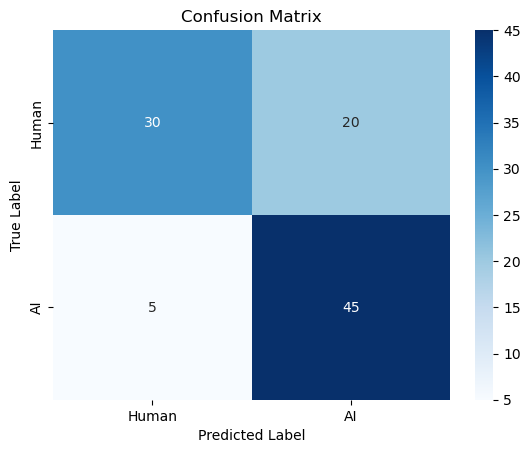

In [20]:
# Plot confusion matrix
sns.heatmap(evaluation['confusion_matrix'], annot=True, fmt='d', 
                xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'],cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

----
## Write the results dataframe to a CSV file
----

In [21]:
 # Save results
results_df.to_csv("classification_results_caching.csv", index=False)

----
## Validate the model results by calling the cache file created to save the model outputs
----

In [33]:
import json
import random
import re

# Load the existing cache file (assuming it's named "response_cache.json")
cache_file = "response_cache.json"
with open(cache_file, "r") as f:
    cache = json.load(f)

# Randomly select 5 keys from the cache
random_keys = random.sample(list(cache.keys()), 5)

for key in random_keys:
    verdict, confidence, response = cache[key]
    
    # Extract evidence for Human and AI using regular expressions
    evidence_human_match = re.search(r"Evidence for Human:\s*(.*?)\s*Evidence for AI:", response, re.DOTALL)
    evidence_ai_match = re.search(r"Evidence for AI:\s*(.*?)\s*Confidence:", response, re.DOTALL)
    
    evidence_human = evidence_human_match.group(1).strip() if evidence_human_match else "No evidence found for Human."
    evidence_ai = evidence_ai_match.group(1).strip() if evidence_ai_match else "No evidence found for AI."
    
    # Print the results for each random text
    print("Random Text Key:", key)
    print("Final Verdict:", verdict)
    print("Confidence Score:", confidence)
    print("\nEvidence for Human:")
    print(evidence_human)
    print("\nEvidence for AI:")
    print(evidence_ai)
    print("\n" + "-"*50 + "\n")


Random Text Key: -5051923105673325132
Final Verdict: AI
Confidence Score: 60

Evidence for Human:
No evidence found for Human.

Evidence for AI:
- The repetition of the phrase "there is no onesizefitsall approach to positivity" could suggest AI authorship, as AI sometimes repeats phrases due to its training on large datasets.
- The text contains a minor typo "onesizefitsall" which should be "one-size-fits-all". This could be a result of AI not recognizing the need for hyphenation in this compound adjective.
- The text lacks a certain depth of emotion or personal experience, which could suggest AI authorship.

--------------------------------------------------

Random Text Key: 8191352326853930504
Final Verdict: AI
Confidence Score: 95

Evidence for Human:
No evidence found for Human.

Evidence for AI:
- There are numerous instances of nonsensical abbreviations and phrases such as "TWD policy's", "TD NDT", "Due cell phones", "DFF", "DN", "FDR", "fine", "Dan't", "fellow", which do not ma